<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [3]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [4]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**
При использовании слишком большого batch_size, используется много памяти на хранение градиентов, особенно для моделей с большим количеством параметров, что приводит к замедленной скорости обучения. Кроме того, использование слишком большого batch_size может привести к застреванию в локальных минимумах и затруднить поиск глобальных минимумов.

Посмотрим на какую-нибудь картинку:

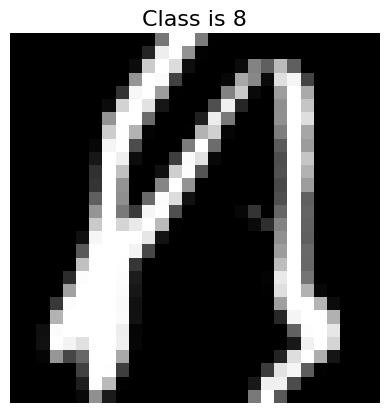

In [5]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





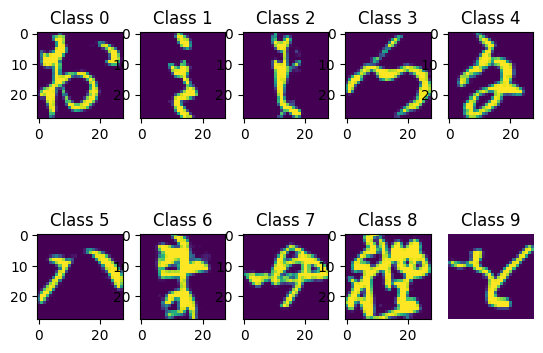

In [6]:
import random

examples = []
for p in range(10):
    class_indices = [i for i in range(len(trainset)) if trainset[i][1] == p]
    random_index = random.choice(class_indices)
    examples.append(trainset[random_index][0])

fig, axs = plt.subplots(2, 5)
for i in range(2):
    for j in range(5):
        axs[i, j].imshow(examples[5*i + j].reshape(28, 28, 1))
        axs[i, j].set_title('Class ' + str(5*i + j))
plt.axis("off");

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [7]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)  # делаем изображение вектором
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**
В данной модели первый полносвязный слой имеет 256 входных и 128 выходных признаков, второй - 128 входных и 128 выходных признаков, а последний - 128 входных и 10 выходных признаков.

Таким образом, общее количество обучаемых параметров:
256128 + 128128 + 128*10 = 34144

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [8]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [9]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [10]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9122
Epoch=2 loss=0.4389
Epoch=3 loss=0.3468
Epoch=4 loss=0.2912
Epoch=5 loss=0.2503
Epoch=6 loss=0.2163
Epoch=7 loss=0.1903
Epoch=8 loss=0.1657
Epoch=9 loss=0.1454
Epoch=10 loss=0.1293


In [11]:
get_accuracy(fc_net, testloader)

0.8775

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [12]:
train_images = next(iter(trainloader))[0]
mean = train_images.mean() ## calculate mean
std = train_images.std() ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1935) tensor(0.3501)


In [13]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [14]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6935
Epoch=2 loss=0.3078
Epoch=3 loss=0.2278
Epoch=4 loss=0.1767
Epoch=5 loss=0.1412
Epoch=6 loss=0.1132
Epoch=7 loss=0.0928
Epoch=8 loss=0.0754
Epoch=9 loss=0.0618
Epoch=10 loss=0.0506


In [15]:
get_accuracy(fc_net, testloader)

0.9005

Как изменилась `accuracy` после нормализации?

Значение `accuracy` увеличилось с 0.8775 до 0.9005

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [16]:
## YOUR CODE HERE
class FCNetAct(nn.Module):
    def __init__(self, activation):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)  # делаем изображение вектором
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

In [17]:
n_epochs = 10
loss_history = []
activations = {'sigmoid': nn.functional.sigmoid, 'gelu': nn.functional.gelu, 'tanh': nn.functional.tanh}
results = {}

for act_name, activation in activations.items():
    print(f'Training with {act_name} activation')
    fc_net = FCNetAct(activation)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

    accuracy = get_accuracy(fc_net, testloader)
    print(f'Accuracy for {act_name} activation: {accuracy:.4f}')


Training with sigmoid activation
Epoch=1 loss=1.5620
Epoch=2 loss=0.7561
Epoch=3 loss=0.5489
Epoch=4 loss=0.4444
Epoch=5 loss=0.3739
Epoch=6 loss=0.3200
Epoch=7 loss=0.2762
Epoch=8 loss=0.2414
Epoch=9 loss=0.2127
Epoch=10 loss=0.1874
Accuracy for sigmoid activation: 0.8555
Training with gelu activation
Epoch=1 loss=1.5620
Epoch=2 loss=0.7561
Epoch=3 loss=0.5489
Epoch=4 loss=0.4444
Epoch=5 loss=0.3739
Epoch=6 loss=0.3200
Epoch=7 loss=0.2762
Epoch=8 loss=0.2414
Epoch=9 loss=0.2127
Epoch=10 loss=0.1874
Accuracy for gelu activation: 0.9064
Training with tanh activation
Epoch=1 loss=1.5620
Epoch=2 loss=0.7561
Epoch=3 loss=0.5489
Epoch=4 loss=0.4444
Epoch=5 loss=0.3739
Epoch=6 loss=0.3200
Epoch=7 loss=0.2762
Epoch=8 loss=0.2414
Epoch=9 loss=0.2127
Epoch=10 loss=0.1874
Accuracy for tanh activation: 0.9018


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Для Sigmoid `accuracy` равен 0.8555, для GELU -- 0.9064, а для Tanh -- 0.9018. Таким образом, при learning rate 3e-4 лучшей функцией активации является GELU.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [21]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = x.view(-1, 28*28)  # делаем изображение вектором
        x = self.fc1(x)
        x = nn.functional.gelu(x)
        x = self.fc2(x)
        x = nn.functional.gelu(x)
        x = self.fc3(x)
        return x

loss_function = nn.CrossEntropyLoss()
lr = 0.001
n_epochs = 10

fc_net = FCNet()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=lr)

loss_history = []
for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())

accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy for Adam activation: {accuracy:.4f}')

fc_net = FCNet()
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=lr)

loss_history = []
for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())

accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy for RMSprop activation: {accuracy:.4f}')

fc_net = FCNet()
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=lr)

loss_history = []
for epoch in range(n_epochs):
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())

accuracy = get_accuracy(fc_net, testloader)
print(f'Accuracy for Adagrad activation: {accuracy:.4f}')

Accuracy for Adam activation: 0.9034
Accuracy for RMSprop activation: 0.9090
Accuracy for Adagrad activation: 0.8099


Мы можем видеть, что RMSprop показывает лучшую точность на тестовых данных, а Adagrad - наихудшую.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [22]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.max(x, torch.zeros_like(x))

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [23]:
n_epochs = 10
loss_history = []
activations = {'ReLU': nn.functional.relu, 'CustomReLU': CustomReLU}
results = {}

for act_name, activation in activations.items():
    print(f'Training with {act_name} activation')
    fc_net = FCNetAct(activation)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

    accuracy = get_accuracy(fc_net, testloader)
    print(f'Accuracy for {act_name} activation: {accuracy:.4f}')

Training with ReLU activation
Epoch=1 loss=0.6677
Epoch=2 loss=0.2852
Epoch=3 loss=0.2047
Epoch=4 loss=0.1563
Epoch=5 loss=0.1235
Epoch=6 loss=0.0985
Epoch=7 loss=0.0795
Epoch=8 loss=0.0638
Epoch=9 loss=0.0507
Epoch=10 loss=0.0399
Accuracy for ReLU activation: 0.9026
Training with CustomReLU activation
Epoch=1 loss=0.6677
Epoch=2 loss=0.2852
Epoch=3 loss=0.2047
Epoch=4 loss=0.1563
Epoch=5 loss=0.1235
Epoch=6 loss=0.0985
Epoch=7 loss=0.0795
Epoch=8 loss=0.0638
Epoch=9 loss=0.0507
Epoch=10 loss=0.0399
Accuracy for CustomReLU activation: 0.9048


Точность CustomReLU и ReLU различается в третьем знаке, т.е. можно считать, что ничего не изменилось.

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Изображение сгенерировано моделью ruDALL-E от Сбера по запросу "Когда ты прогнал свою модель машинного обучения и получил результат, но не можешь понять, что с ним делать"

![](/home/kate/bioinf/ML/fifth_hw/photo_2023-04-20_13-43-15.jpg)
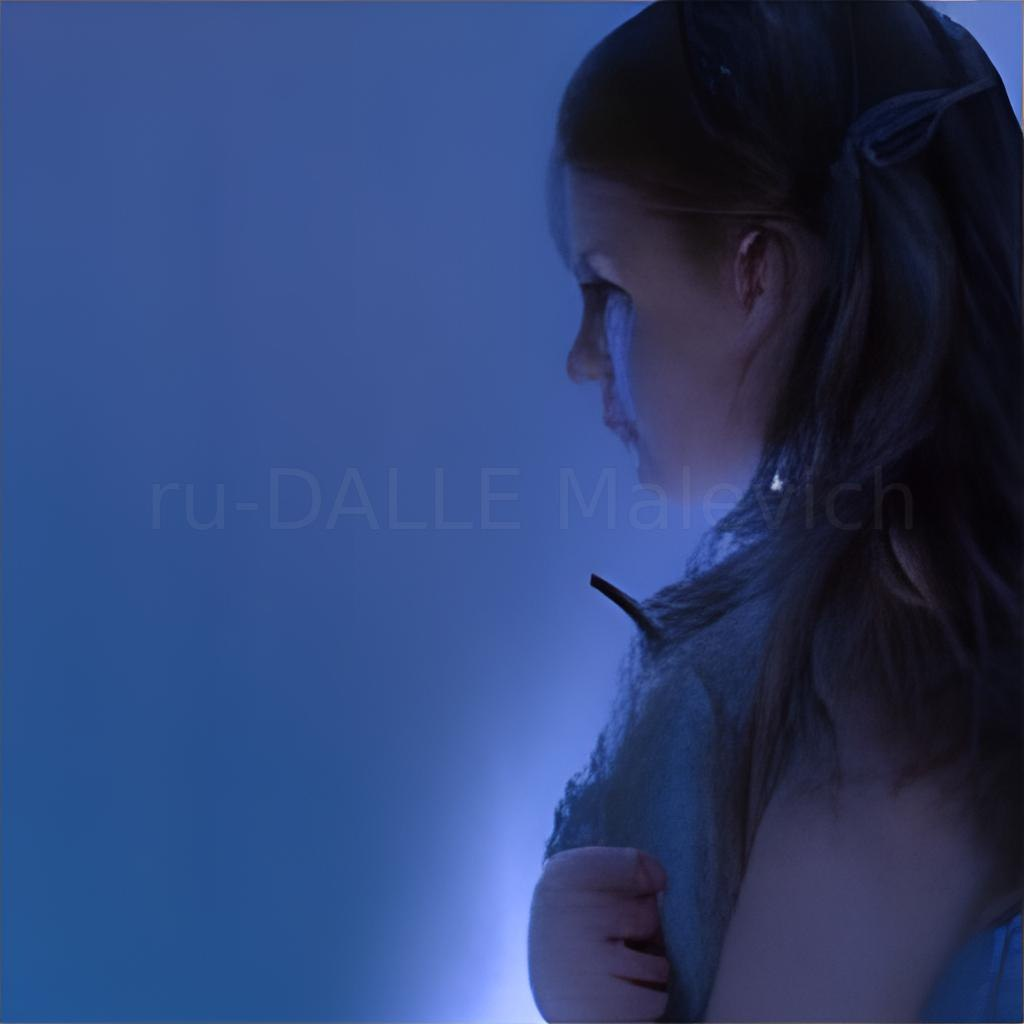

Изображение сгенерировано моделью ruDALL-E от Сбера по запросу "Густой туман опускался на город, окутывая его в серый пелену, и только яркие огни магазинов пробивались сквозь него, создавая красивые и завораживающие отражения на мокром асфальте"

![](/home/kate/bioinf/ML/fifth_hw/photo_2023-04-20_13-56-13.jpg)
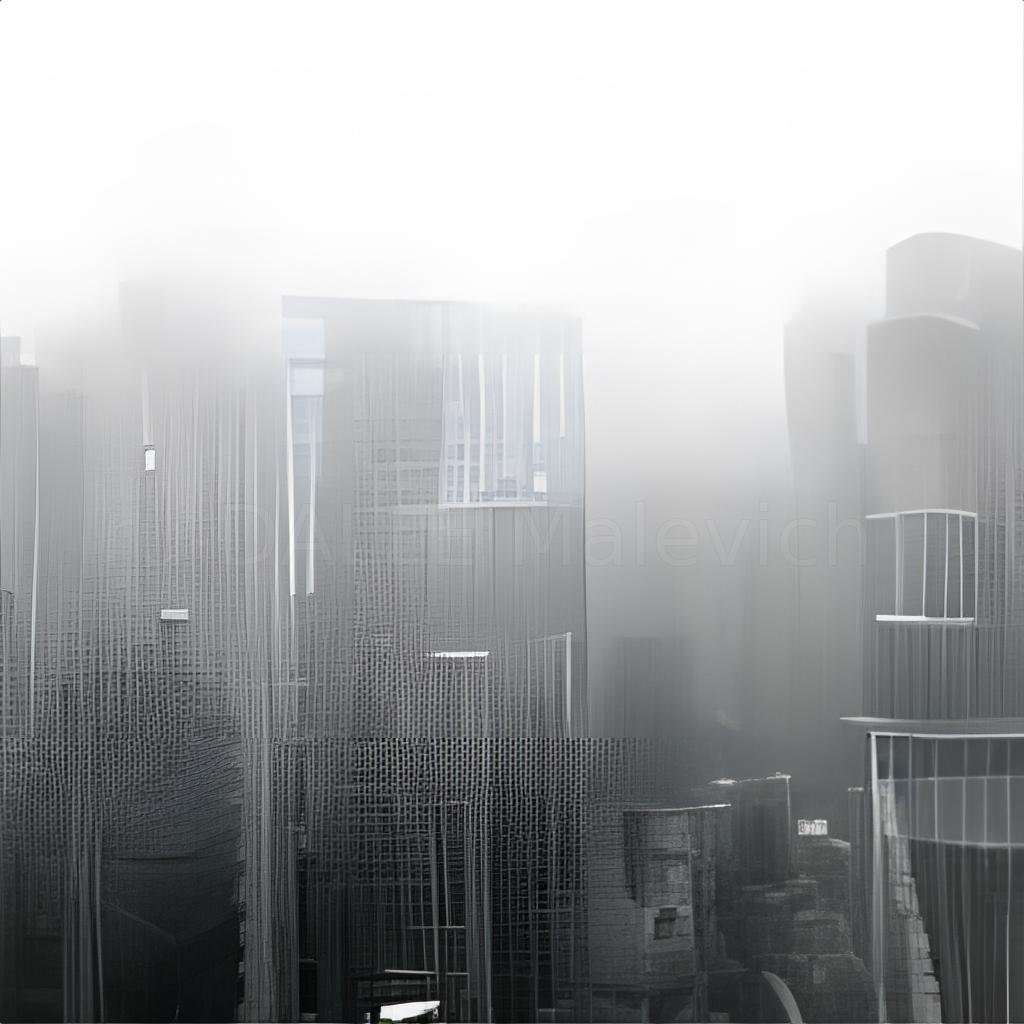

Изображение сгенерировано моделью ruDALL-E от Сбера по запросу "Солнце, казалось, низко висело на горизонте, когда красные и золотые оттенки заполнили небо, окрашивая его в цвета огня. Луг расстилался внизу, обрамленный густой рощей, а ковер из ярких цветов тянулся по его поверхности, словно попытка уловить последние лучи солнца перед закатом."

![](/home/kate/bioinf/ML/fifth_hw/photo_2023-04-20_13-59-03.jpg)